In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5
import os

from vortrace import vortrace as vt

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [3]:
name = 'MW3_MHG0.25_GSE6_kick'
# nameiso = 'MW3iso_fg0.7_MHG0.25_RC9-lvl4'

In [4]:
snap = 300
MC = h5.File(basepath + 'anlys/MC/' + name + '-lvl4/MC_Prop_' + str(snap).zfill(3) + '.h5', mode='r')
sn = arepo.Snapshot(basepath + 'runs/' + name + '/lvl4/output', snap, parttype=0, combineFiles=True)
COM = np.load(basepath + 'anlys/COM/COM_' + name + '-lvl4.npy', allow_pickle=True).item()

In [5]:
def get_massMC(ParticleIDs, ParentIDs, TracerMass):
    massMC = np.zeros(np.shape(ParticleIDs))

    partid_sort = np.argsort(ParticleIDs)
    parentid_sort = np.argsort(ParentIDs)

    i = j = 0
    while i < len(ParentIDs):
        parentid = ParentIDs[parentid_sort[i]]
        partid = ParticleIDs[partid_sort[j]]

        if parentid == partid:
            massMC[partid_sort[j]] += TracerMass
            i += 1
        else:
            j += 1
    
    return massMC

In [28]:
def _compute_gas_projection(pos, rho, BoxSize, COM, rng, nres, yaw=0, pitch=0, roll=0):
    pc = vt.ProjectionCloud(pos, rho, boundbox=[0., BoxSize, 0., BoxSize, 0., BoxSize])

    extent_xy = [[COM[0] + rng[0][0], COM[0] + rng[0][1]], [COM[1] + rng[1][0], COM[1] + rng[1][1]]]
    extent_xz = [[COM[0] + rng[0][0], COM[0] + rng[0][1]], [COM[2] + rng[1][0], COM[2] + rng[1][1]]]

    bounds = [0., BoxSize]

    dat_xy = pc.projection(extent_xy, nres, bounds, COM, proj='xy')
    
    dat_xz = pc.projection(extent_xy, nres, bounds, COM, yaw=yaw, pitch=pitch, roll=roll)
    
    return dat_xy, dat_xz

In [46]:
pos = sn.part0.pos.value
rho = sn.part0.rho.value
mass = sn.part0.mass.value
vol = mass/rho

is_gas = MC['PartType5/PartType'][:] == 0
is_CGM = MC['PartType5/Membership'][:] == 1
is_GSE = MC['PartType5/Membership'][:] == 2
is_cold = MC['PartType5/Temperature'][:] < 3E4
is_cold_CGM = np.logical_and(np.logical_and(is_gas, is_CGM), is_cold)
is_cold_GSE = np.logical_and(np.logical_and(is_gas, is_GSE), is_cold)

massMC_CGM = get_massMC(sn.part0.ParticleIDs, MC['PartType5/ParentID'][is_cold_CGM],
                            MC['Header'].attrs['TracerMass'])

massMC_GSE = get_massMC(sn.part0.ParticleIDs, MC['PartType5/ParentID'][is_cold_GSE],
                            MC['Header'].attrs['TracerMass'])

rhoMC_CGM = massMC_CGM / vol
rhoMC_GSE = massMC_GSE / vol

BoxSize = sn.BoxSize

rng = [[-140, 140], [-140, 140]]
nres = 128

# yaw = np.pi/2.
yaw = 0.
# pitch = (10./180.) * np.pi
pitch = np.pi/4.
# roll = np.pi/2.
roll = 0.
# pitch = 0.
# roll = 0.

print(COM['MW_COM'][snap])

Hxy_g_CGM, Hxz_g_CGM = _compute_gas_projection(pos, rhoMC_CGM, BoxSize, COM['MW_COM'][snap], rng, nres,
                                              yaw=yaw, pitch=pitch, roll=roll)
# Hxy_g_GSE, Hxz_g_GSE = _compute_gas_projection(pos, rhoMC_GSE, BoxSize, COM['MW_COM'][snap], rng, nres)

[282.37412341 324.78611203 276.876406  ]
Applying bounding box...
npart: 653540
Snapshot loaded.
Building tree...
Tree build took 103 milliseconds.
Making projection...
Projection generation took 2073 milliseconds.
Making projection...
Projection generation took 2227 milliseconds.


Text(0.5, 0, 'x [kpc]')

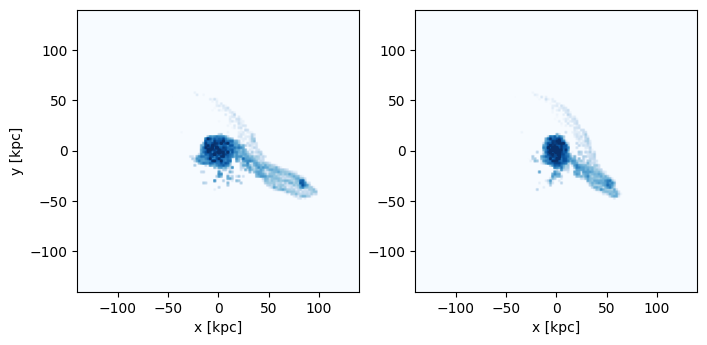

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

vmin = 1E-6
vmax = 1E-3

extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]

# Hxy_g_plot_GSE = np.copy(Hxy_g_GSE)
Hxy_g_plot_CGM = np.copy(Hxy_g_CGM)
Hxz_g_plot_CGM = np.copy(Hxz_g_CGM)

# Hxy_g_plot_GSE[Hxy_g_GSE < vmin] = vmin
Hxy_g_plot_CGM[Hxy_g_CGM < vmin] = vmin
Hxz_g_plot_CGM[Hxz_g_CGM < vmin] = vmin

ax[0].imshow(Hxy_g_plot_CGM.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), 
             cmap='Blues', extent=extent)

ax[1].imshow(Hxz_g_plot_CGM.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), 
             cmap='Blues', extent=extent)


ax[0].set(xlabel='x [kpc]', ylabel='y [kpc]')
ax[1].set_xlabel('x [kpc]')

In [49]:
(6.5/200) * (180/np.pi)

1.8621128341751756

Text(0.5, 0, 'x [kpc]')

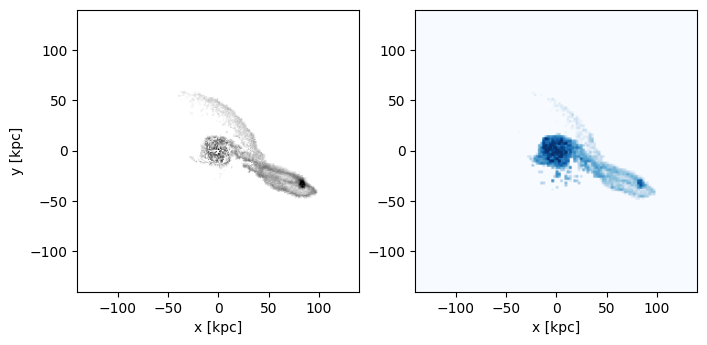

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

vmin = 1E-6
vmax = 1E-3

extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]

Hxy_g_plot_GSE = np.copy(Hxy_g_GSE)
Hxy_g_plot_CGM = np.copy(Hxy_g_CGM)

Hxy_g_plot_GSE[Hxy_g_GSE < vmin] = vmin
Hxy_g_plot_CGM[Hxy_g_CGM < vmin] = vmin

ax[0].imshow(Hxy_g_plot_GSE.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), 
             cmap='Greys', extent=extent)
ax[1].imshow(Hxy_g_plot_CGM.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), 
             cmap='Blues', extent=extent)

ax[0].set(xlabel='x [kpc]', ylabel='y [kpc]')
ax[1].set_xlabel('x [kpc]')